In [2]:
import pandas as pd
import numpy as np
from pyproj import Proj,transform
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
warnings.filterwarnings("ignore")

In [24]:
str_name = '2014-02 - Citi Bike trip data.csv'
data = read_data(str_name)
print(data.info())
# str_name2 = '2014-02 - Citi Bike trip data.csv'
# data1 = read_data(str_name)
# data2 = read_data(str_name2)
# data = pd.concat([data1,data2],axis=0,ignore_index=True)

def get_projXY(idx,data):
    # calculate projected coordinates of input data
    data_num = len(idx)
    CoordsX1 = []
    CoordsY1 = []
#     CoordsX2 = []
#     CoordsY2 = []
    point = Proj(init='epsg:32118')
    for i in range(data_num):
        x1,y1 = point(data['start station longitude'][idx[i]],data['start station latitude'][idx[i]])
#         x2,y2 = point(data['end station longitude'][idx[i]],data['end station latitude'][idx[i]])
        CoordsX1.append(x1)
        CoordsY1.append(y1)
#         CoordsX2.append(x2)
#         CoordsY2.append(y2)
    return CoordsX1,CoordsY1#,CoordsX2,CoordsY2
def set_episode(d):
    d['episode'][d['starttime'].dt.hour<11]=0
    d['episode'][((d['starttime'].dt.hour>=11) & (d['starttime'].dt.hour<12))|((d['starttime'].dt.hour>=16) & (d['starttime'].dt.hour<17))] = 1
    d['episode'][(d['starttime'].dt.hour>=12) & (d['starttime'].dt.hour<16)] = 2
    d['episode'][(d['starttime'].dt.hour>=17) & (d['starttime'].dt.hour<18)] =3
    d['episode'][d['starttime'].dt.hour>=18] = 4
    return d
def read_data(str):
    data = pd.read_csv(str)
    data = data.drop(['usertype','birth year','gender'],axis=1)
    # project data
    x1,y1= get_projXY(data.index,data)
    data['x1'] = x1
    data['y1'] = y1
    data['starttime'] = pd.to_datetime(data['starttime'],format='%Y-%m-%d %H:%M:%S')
    #data['stoptime'] = pd.to_datetime(data['stoptime'],format='%Y-%m-%d %H:%M:%S')
    data['start timestamp'] = (data['starttime']-pd.to_datetime('2013-07-01 00:00:00')).dt.total_seconds()
    data_time_filter = data[(data['starttime'].dt.hour<23)&(data['starttime'].dt.hour>=7)]
    # set episode
    data_time_filter['episode']=np.zeros(len(data_time_filter))
    data_time_filter = set_episode(data_time_filter)
    # set time index
    #data_time_filter.index = data_time_filter['starttime']
    # set cluster
    data_time_filter['cluster']=np.zeros(len(data_time_filter))
    return data_time_filter

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210754 entries, 582 to 224606
Data columns (total 17 columns):
tripduration               210754 non-null int64
starttime                  210754 non-null datetime64[ns]
stoptime                   210754 non-null object
start station id           210754 non-null int64
start station name         210754 non-null object
start station latitude     210754 non-null float64
start station longitude    210754 non-null float64
end station id             210754 non-null int64
end station name           210754 non-null object
end station latitude       210754 non-null float64
end station longitude      210754 non-null float64
bikeid                     210754 non-null int64
x1                         210754 non-null float64
y1                         210754 non-null float64
start timestamp            210754 non-null float64
episode                    210754 non-null float64
cluster                    210754 non-null float64
dtypes: datetime64[ns](1

(210754, 18)
(327, 327)


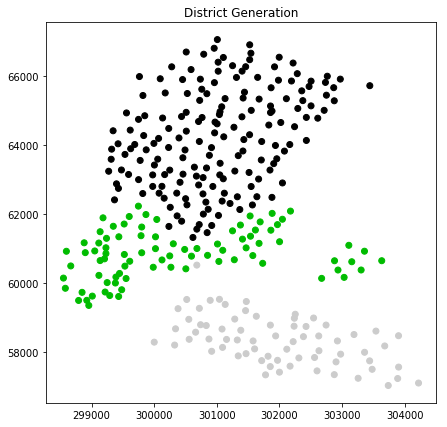

(328, 328)


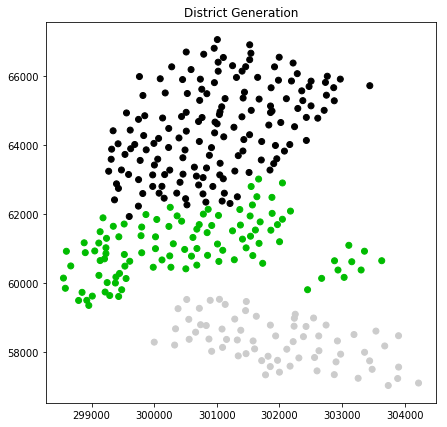

(329, 329)


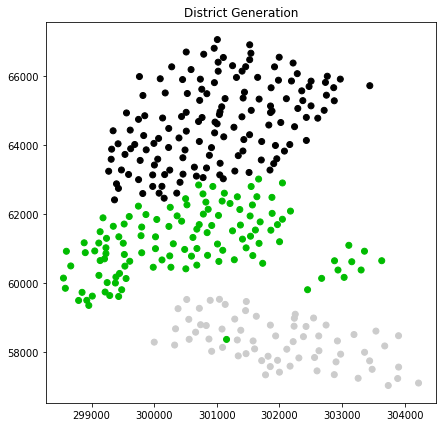

(327, 327)


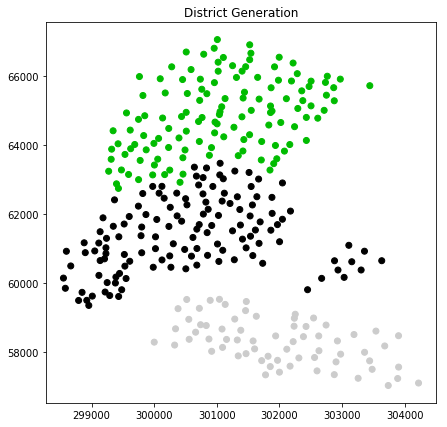

(328, 328)


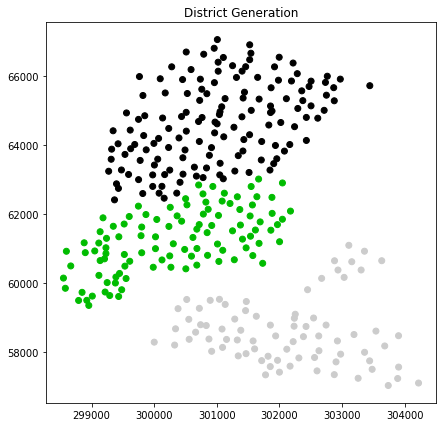

49606
9567
27407
6511
55374
13602
22402
5761
55932
14233


In [23]:
def get_station_transition_num_matrix(data):
    station = pd.unique(data['start station id'])
    station_num = len(station)
    trans_mx = np.zeros((station_num, station_num))
    for i in range(len(station)):
        s_ = station[i]
        e_ = data['end station id'][data['start station id']==s_]
        #print(e_==s_)
        for j in range(len(e_)):
            trans_mx[i][station==e_.iloc[j]] +=1
    return trans_mx

def community_cleaning(data):
    ep_datas = []
    for p in range(5):
        ep_data = data[data['episode']==p]
        ep_data = ep_data[ep_data['end station id'].isin(ep_data['start station id'])] # remove the usless end region
        region_mapping = {i: c for i, c in ep_data[['start station id', 'community']].values}
        ep_data['end community'] = ep_data['end station id'].replace(region_mapping)
        l1 = len(ep_data)
        ep_data = ep_data[ep_data['community'] == ep_data['end community']]
        l2 = len(ep_data)
        print(l1)
        print(l1-l2)
        ep_datas.append(ep_data)
    return pd.concat(ep_datas)

print(data.shape)
# community generation 
# for loop for period
data['community'] = np.zeros(len(data))
for p in range(5):
    n_clusters = [3,3,3,3,3]
    ep_data = data[data['episode']==p]
    station = pd.unique(ep_data['start station id'])
    trans_mx = get_station_transition_num_matrix(ep_data)
    print(trans_mx.shape)
    A = kneighbors_graph(trans_mx,30, mode='connectivity', include_self=False)
    model = AgglomerativeClustering(connectivity=A,n_clusters=n_clusters[p],compute_full_tree=1)
#     print(A.toarray())
    rxy_ = ep_data[['start station id','x1','y1']].drop_duplicates()
    rxy = np.array(rxy_[['x1','y1']])
    model.fit(rxy)
    rxy_['labels']=model.labels_
#     print(model.labels_)
#     print(model.n_leaves_)
    # save file
    for j in range(len(rxy)):
        ep_data['community'][ep_data['start station id']==rxy_['start station id'].iloc[j]] = rxy_['labels'].iloc[j]
    #print(p_region['community'])
    data['community'][data['episode']==p] = ep_data['community']
    plt.figure(figsize=(7,7))
    plt.scatter(rxy[:, 0], rxy[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
    plt.title('District Generation')
    plt.savefig('DG'+str(p)+'.png',dpi=600,bbox_inches='tight')
    plt.show()

data_ = community_cleaning(data)
data_ = data_.drop(['end community'],axis=1)

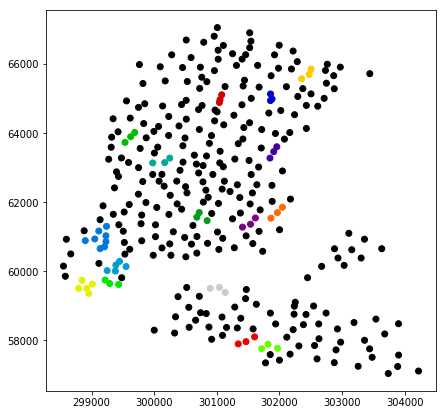

end dbscan initalization
before dbscan: 327
after dbscan: 286
before dbscan: 328
after dbscan: 287
before dbscan: 329
after dbscan: 288
before dbscan: 325
after dbscan: 284
before dbscan: 328
after dbscan: 287


In [6]:
from sklearn.cluster import DBSCAN
# dbscan
data_['cluster'] = np.zeros(len(data_))
rxy_ = data_[['start station id','x1','y1']].drop_duplicates()
rxy = np.array(rxy_[['x1','y1']])
clustering = DBSCAN(eps=200, min_samples=3).fit(rxy)
rxy_['labels']=clustering.labels_+1
for j in range(len(rxy)):
    data_['cluster'][data_['start station id']==rxy_['start station id'].iloc[j]] = rxy_['labels'].iloc[j]
plt.figure(figsize=(7,7))
plt.scatter(rxy[:, 0], rxy[:, 1], c=clustering.labels_,
                    cmap=plt.cm.nipy_spectral)
plt.show()
print('end dbscan initalization')
# merge small station
for i in range(5):
    ep_data = data_[data_['episode']==i]
    station = pd.unique(ep_data['start station id'])
    cluster = pd.unique(ep_data['cluster'])
    for j in range(len(cluster)):
        if cluster[j] !=0:
            start_ids = ep_data['start station id'][ep_data['cluster'].values == cluster[j]].unique() # station id in the cluster
            mappings = {start_id: start_ids[0] for start_id in start_ids}
            ep_data['start station id'] = ep_data['start station id'].replace(mappings)
            ep_data['end station id'] = ep_data['end station id'].replace(mappings)
            ep_data['x1'][ep_data['cluster'].values == cluster[j]] = ep_data['x1'][ep_data['cluster'].values == cluster[j]].values[0]
            ep_data['y1'][ep_data['cluster'].values == cluster[j]] = ep_data['y1'][ep_data['cluster'].values == cluster[j]].values[0]
            
#             start_s = ep_data['start station id'][np.array(ep_data['cluster'])==cluster[j]]
#             start_s0 = start_s.iloc[0]
#             ep_data['start station id'][np.array(ep_data['cluster'])==cluster[j]] = start_s0
    data_['start station id'][data_['episode']==i] = ep_data['start station id']
    data_['end station id'][data_['episode']==i] = ep_data['end station id']
    data_['x1'][data_['episode']==i] = ep_data['x1']
    data_['y1'][data_['episode']==i] = ep_data['y1']
    print('before dbscan:',len(station))
    print('after dbscan:',len(pd.unique(ep_data['start station id'])) )
# hierarchical clustering

[15  0 13 11 10  6  6 12  1  0 15 14 14 13 18  6  7  9  5 14 15 17  0 15
 14 16 10 14  1  1  0 15  1  1  7 10  7 14 10 10 13  6  9  3 16 15  4  1
 15 15 13 16  6  4  3 15  5 19  1  5  1 12 13  4  1  6  5 14  1 15  2  1
  4  7  3 13  3  0 17 14 14  9 14  7  1 14  1  2 16  1  7 11 15  7 19 10
  3  9 14  7 12 16 13 16  1 13 10 13  5  6 17 15  3  0 13 10 19  2 19 13
 19 13  2  1 16  5  9 15 10 16  4  4 14 14 10 17 16 17  0  1 16 13  0  7
  3  3 19 13  2  4  8 19 17  1 18  4 17  3  3 11  6 19  0  3  9 11 17  4
  1  3  2 19  0 12 16 17 10 11  0 17 19  7  3  1  8  2  9  3  6 18  2  5
  2 13 14 15  9  5 18  7  7  7  8 11  6  3  5  0 11  5  8  9  9  5 12  0
  3 12 12 19  4  1  7  9  0 12 19 12  1  7 10 19  8 13  3 11  5  5 15  8
  2  3 10 10  0  3 18  0 19 18 18 18  7  8  9  2  4  0  0  0  3  0  2  2
  0 13  8  1  0  0  2  9  2 18 18  2  0  0  8 11  2  5  6  6 18  5]
286


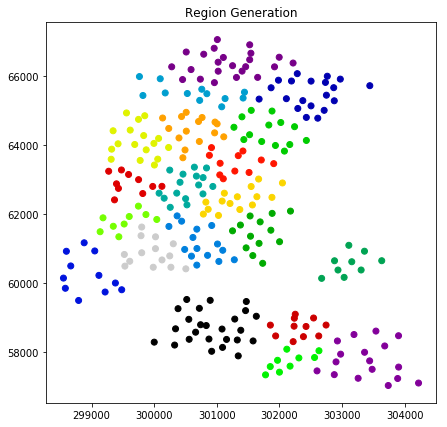

[14  4  3 17  5 13  1  7  6  1 11 14  7  8 16  7  7  7 14  7  8  7 17  6
 10 13 14  8  8  8 13  7  7 15  7 12  3 14 12  0  0  7 10 15 10 17  7 17
 19  7  1 10  6 10  2  9 10 11  0  9 18  7  4  1  3 12  5  3 19  6 17  1
  1 19  7 18 14  0 15 15 15  0 17  7 18 16  2 16 17  1  0 12  9 17  6  6
  6 15 10  8 11  8  7 10  4 12 19  0 10  3  5 14 14 14  6  7  4  5  1  4
 18  6  1  4  6 12  9  1  6 18  4 15 10  5  3 12  8  9  8 14  8 12  8  6
 19  1 11  4  3 16  3  4 12  1 10  8  4 14  1  0  0  2 11  9  0 12  6  4
  0 10 17 18  8 14  8 17  1  5  6 17  1  4  8  2  0 11  6  1 15 18  3 19
 17  5  5 10  2  8  3  8 11 11  1  0  5  4  4  2  1  4 15  9  6 15  6 10
 10 11  2  0 14  2  3  8  3  4  3  0  2  3  8 17 11  4  9 14 11  0 13 11
 18 19  0  2 15  6  9  4  5 19  9 12 16 11 18 13  0  9  2 13  5 15 13  9
 11  9 16  0  0 13 16  0  0 13 16 16  2  0 13  2  0 12 12  0  1 16 16]
287


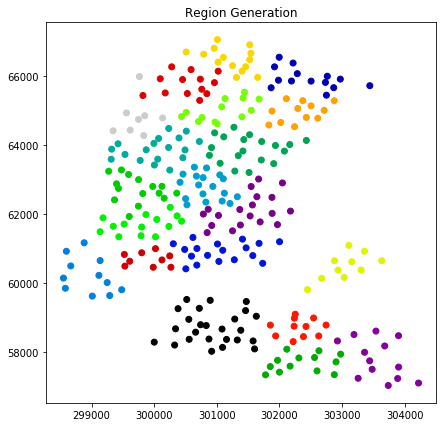

[13  0  9 13 17  0  0  0 11  8  1 16 15  8  0 13 12  8  9  6  9  2 11  5
  8 15 12  1  0  8  6  4  5  0  0 15 12  4  9 11  6  9  8 10  9  0  9 12
  1  9  1  8  9  0  7  3  6  4 11 11 16 12 13  8  0  1 12  5  7  7 12 16
  9 11 11  6 13 12 19  0 12  8  3 11  3 13  8  0  8 12  6  0 14  0  7  0
 16  6  1  9  1  1  8 14 12  7 15 19 13  0  6  1  0  1 13  0 11 19  3  5
  8 12 16  1  3 18 16  0  6  3  6  3 12  4 15  1  4  0 11  7 10  4  7  2
  6  4 11 11 12  4 17 16 12  3 19  7 10  1 11 11  2  1  3 15  2  0  0 16
 11 16  1 13  9  4  3  7 17  3  7 17  2  6  6  5 19  7 12  3 17  7  5  7
  0 16 14  4 13  1 15  9 14 16  4  2  1  8 11  7 11  6 12 13  9  7 13 10
  5 19 19  5  7  7 17 11  7  5  5 16 15  2  1 14  3 16  2 15  9  5  2  2
  3  9  5 14  5  2  5  0  5  5  7 15  3  3  2  2  2  5 14  2 14  5  0 10
  3 14 10 10  5  2  5  0 10  5  2  2  2  5 14 10 10  5  8 19 17 17 10 11]
288


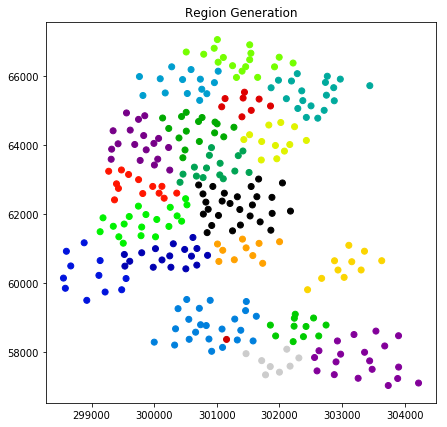

[ 2  8 16  3  0  8 11  1  4  8  7  3 17 12  2 14 11  0  3  8  7  6  3  3
 11  6 15  1  2  3  6 16  8  3 16 18  0  5 11 10 11 12 13 18  0 14  1  6
 12  9  3  2  8  3  0  7  1 15 15  7  5 17  1  2 11 14  2  3 17  3  7  8
  1  1 10  4 14  7 11 18 15  4 17  6 11 12 12  5 15 16  4 14  2 15  6  4
  0 15 12  1  7 15 12  7 15  1 11 14 10  0  1  0  4 14 14  1 14 17  4  8
  1 13  6  4 18  3 14  3  4  7 15  2 12  2 11  5  0 10  0 10  7  0  8 12
 16 14 12  5  4 16  3  3 15 11 16  1 12 11 19 11 11 14  1  2  3 14  3 11
 10  6  1  2  0  0  6 15 10  6  3 18 10  6 19  4 12  7 16 17  5 14  6 13
  1 17 17  3  4  0  6  0  2 13  9 13  7  5  2  1 12  1 10  4  2 15 14  8
  6  5  6 19 13  2 11  1  2 10  1 12  0 19 13  2  9 13 16 18  2  3  9  7
 10  9  4 19 11 13 17  7 12  4  5 16  4 15  5  9  5  5  9  2  8 14 13 16
  5  5  2  2  9  2  2 13  5  5 12  5  2  0  0  2  9  5 13  5]
284


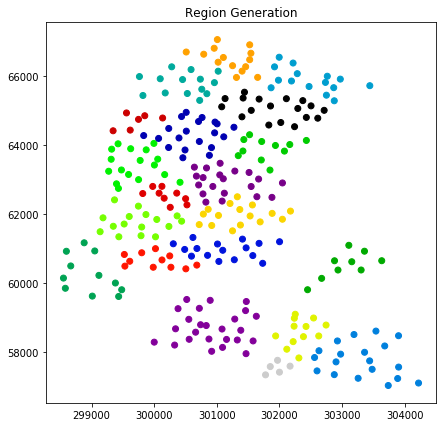

[18 18 13  9  3 15 18 19 15  6  0 13  2 13  2  8  7  4  2 15 15 15  2  8
 15 11  6  6  4 11  1 11 11 19 16 18 18 12  2 16 11 11  7  3  1  3  3 13
 10  6  2  3  6 17 14 14 15 17 11 14 19 18 14  2 16  3 19 14  0  4  1  3
  3  4  1  0  9 13 13 11 14  1  6  3  9 14  8 18  5  6 10 14 18  4 10 14
 10  7  6  4  6 12  9  8  7 11 15  6  7  6  2  1  6  3 17 14  1  5 13  1
  2 15 17  6 14  0  6  6  8 13 12  2  3  7  4  2  8 13 14 14 11 12 18  0
 11  3 18  0 15 16 17 17 17  7 13  2 10 13 17 13 12 17 17 16 11  4  1 19
 14 11  1  2 14  7  3  2  8  2 17  4 12 12  9 10  5  2  9  8  0 13 10  7
  4  6 16  8  0 15  1 12 19  0  1 19 12 10  5 13  3  4  5  6  4  0  0  0
 10  2  0  4 12 13 10  5  5  5  3  5  4  5  7 13  3 17 17 14  3 12 13  4
  1  5  5 19 12 10  0  5  0 13  9 19  4  0  5 18  8  5  5 14  1  7 16  5
  8  7 12  3  9 16  4 12 10 12  5  4  2 16  5  4 12  9  0  9  2 12  1]
287


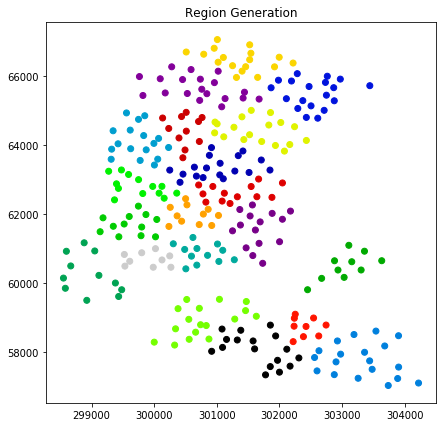

In [21]:
for i in range(5):
    n_clusters = [20,20,20,20,20]
    ep_data = data_[data_['episode']==i]
    trans_mx = get_station_transition_num_matrix(ep_data)
#     print(trans_mx)
    A = kneighbors_graph(trans_mx,30, mode='distance', include_self=False)
    model = AgglomerativeClustering(connectivity=A,n_clusters=n_clusters[p],compute_full_tree=1)
#     print(A.toarray())
    rxy_ = ep_data[['start station id','x1','y1']].drop_duplicates()
    rxy = np.array(rxy_[['x1','y1']])
    model.fit(rxy)
    rxy_['labels']=model.labels_
    print(model.labels_)
    print(model.n_leaves_)
    # save file
    for j in range(len(rxy)):
        ep_data['cluster'][ep_data['start station id']==rxy_['start station id'].iloc[j]] = rxy_['labels'].iloc[j]
    #print(p_region['community'])
    data_['cluster'][data['episode']==i] = ep_data['cluster']
    plt.figure(figsize=(7,7))
    plt.scatter(rxy[:, 0], rxy[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
    plt.title('Region Generation')
    plt.savefig('RG'+str(i)+'.png',dpi=600,bbox_inches='tight')
    plt.show()

In [22]:
print(data_.info())
station_table = data_[['start station id','start station name','x1','y1','episode','cluster','community']].drop_duplicates()
station_table = station_table.reset_index(level=0)
print(station_table.describe())
l_sta = len(station_table)
lat = []
lon = []
for i in range(l_sta):
    p1 = Proj(init='epsg:32118')
    lons, lats = p1(station_table['x1'][i],station_table['y1'][i],inverse=True)
    lon.append(lons)
    lat.append(lats)
station_table['lon'] = lon
station_table['lat'] = lat
station_table.to_csv('station-'+str_name,header=True,index=False)
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161047 entries, 582 to 224606
Data columns (total 18 columns):
tripduration               161047 non-null int64
starttime                  161047 non-null datetime64[ns]
stoptime                   161047 non-null object
start station id           161047 non-null int64
start station name         161047 non-null object
start station latitude     161047 non-null float64
start station longitude    161047 non-null float64
end station id             161047 non-null int64
end station name           161047 non-null object
end station latitude       161047 non-null float64
end station longitude      161047 non-null float64
bikeid                     161047 non-null int64
x1                         161047 non-null float64
y1                         161047 non-null float64
start timestamp            161047 non-null float64
episode                    161047 non-null float64
cluster                    161047 non-null float64
community               

In [18]:
# clustering
# cal transition matrix based on clusters
def get_transition_matrix(station,data):
    clusters = pd.unique(data['cluster'])
    clusters_num = len(clusters)
    trans_mx = np.zeros((len(station),clusters_num))
    for i in range(len(station)):
        s_ = station[i]
        e_ = data['end station id'][data['start station id']==s_]
        for ii in range(len(e_)):
            cluster0 = pd.unique(data['cluster'][data['start station id']==e_.iloc[ii]])    
            #print(len(cluster0))
            cluster0_num = len(cluster0)
            for j in range(cluster0_num):
                trans_mx[i][clusters==cluster0[j]] +=1
        num_sum = np.sum(trans_mx[i])
        trans_mx[i] = trans_mx[i]/num_sum
    #print(trans_mx)
    return trans_mx
##

# region generation
def generate_region(data):
    ep_datas = []
    for p in range(5):
        ep_data = data[data['episode']==p]
  
        station_data = ep_data[['start station id', 'cluster', 'x1', 'y1']].drop_duplicates()
        
        station_mapping = {i: c for i, c in station_data[['start station id', 'cluster']].values}
        #print(station_mapping)
        ep_data = ep_data[ep_data['end station id'].isin(ep_data['start station id'])] # remove the usless end station
        ep_data['start id'] = ep_data['start station id'].replace(station_mapping)
        ep_data['end id'] = ep_data['end station id'].replace(station_mapping)

        ep_data = ep_data[ep_data['start id']!=ep_data['end id']]
        #print('episode', p, (ep_data['start id']==ep_data['end id']).describe())
        
        geo_info = station_data.groupby('cluster').mean()[['x1', 'y1']].reset_index(level=0)
        geo_info.columns = ['start id', 'rx1', 'ry1']
        ep_data = pd.merge(ep_data, geo_info, how='left')
        
        ep_datas.append(ep_data)
    return pd.concat(ep_datas)
########
# cal community
def get_transition_region(data):
    # get region transititon
    # find all unique region
    regions = pd.unique(data['start id'])
    region_num = len(regions)
    # initialize a transition matrix
    trans_mx = np.zeros((region_num,region_num))
    #print(trans_mx)
    # foor loop every region
    for i in range(region_num):
        s_ = regions[i]
        e_ = data['end id'][data['start id']==s_] # 14, Nov 2018
        #print(e_)
        # foor loop every end region
        for ii in range(len(e_)): 
            trans_mx[i][np.array(regions)==e_.iloc[ii]] +=1
        num_sum = np.sum(trans_mx[i])
        trans_mx[i] = trans_mx[i]/num_sum
    #print(trans_mx)
    return trans_mx

####
def generate_community(region):
    for i in range(5):
        n_clusters = [2,3,2,2,2]
        p_region = region[region['episode']==i]
        uni_region = p_region['start id']
    #     print(region.shape)
        region_trans = get_transition_region(p_region)
        print(region_trans.shape)
        A = kneighbors_graph(region_trans,5, mode='connectivity', include_self=True)
    #     print(A)
    #     print(A.toarray())
        rxy_ = p_region[['start id','rx1','ry1']].drop_duplicates()
        rxy = np.array(rxy_[['rx1','ry1']])
    #     print(np.array(rxy))
    #     print(region_unX)
        model = AgglomerativeClustering(connectivity=A,n_clusters=n_clusters[i],compute_full_tree=1)
        model.fit(rxy)
        rxy_['labels']=model.labels_
        print(model.labels_)
        print(model.n_leaves_)
        # save file
        for j in range(len(rxy)):
            p_region['community'][p_region['start id']==rxy_['start id'].iloc[j]] = rxy_['labels'].iloc[j]
        #print(p_region['community'])
        region['community'][region['episode']==i] = p_region['community']
        plt.figure()
        plt.scatter(rxy[:, 0], rxy[:, 1], c=model.labels_,
                            cmap=plt.cm.nipy_spectral)
        plt.show()
    return region
####
def community_clean(data):
    ep_datas = []
    for p in range(5):
        ep_data = data[data['episode']==p]
        ep_data = ep_data[ep_data['end id'].isin(ep_data['start id'])] # remove the usless end region
        region_mapping = {i: c for i, c in ep_data[['start id', 'community']].values}
        ep_data['end community'] = ep_data['end id'].replace(region_mapping)
        l1 = len(ep_data)
        ep_data = ep_data[ep_data['community'] == ep_data['end community']]
        l2 = len(ep_data)
        print(l1)
        print(l1-l2)
        ep_datas.append(ep_data)
    return pd.concat(ep_datas)

def show_inter_independence(df):
    epdf = df
    communities = epdf['community'].unique()
    c = len(communities)
    mat = np.zeros([c]*2)
    for ci in range(c):
        for cj in range(c):
            mat[ci, cj] = len(epdf[(epdf['community'] == ci) &
                               (epdf['end community'] == cj)])
    #print('Episode {}'.format(episode))
    print(mat)
########